<a href="https://colab.research.google.com/github/Kennedy87670/Introduction-to-ML-DP/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 08 Pytorch Paper replicating

The goal of machine learning resaerch paper replicating is: turn a ML research paper into usable code.

we are goint to replicate the Vision Transformer (VIT) archietecture/paper with Pytorch

# 0 setup

In [5]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [6]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3426, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 3426 (delta 52), reused 100 (delta 44), pack-reused 3302
Receiving objects: 100% (3426/3426), 643.49 MiB | 17.44 MiB/s, done.
Resolving deltas: 100% (1959/1959), done.
Updating files: 100% (222/222), done.


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Get Data

In [8]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [9]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## Create Datasets and Dataloaders

In [10]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")


Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


## 2.2 Turn images into Dataloaders

In [11]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f5dfa922460>,
 ['pizza', 'steak', 'sushi'])

# 2.3 Visualize a single image

In [12]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

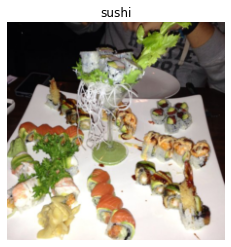

In [13]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating the VIT paper

we can break the code into smaller pieces

## 3.1 Vision Transformer (ViT)

** Equation 1 **
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathrm{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.
**Equation 1**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.



**Equation2 & 3**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

**Equation 4**
Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {claas }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation $y$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.





## Equation 

The MLP contains two layers with a GELU non-linearity.
$$
\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}
$$


## Equation 1 breakdown
In pseudocode:
```python
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3... image_patch_N] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```

## Equation 2 & 3 breakdown
This says that for every layer from 
1
 through to 
L
 (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN).
in pseudocode
```


x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input


x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

```
This says that for every layer from 
1
 through to 
L
 (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

## Equation 4 breakdown

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP =  single layer at fine-tuning time
in pseudocode
```
y = Linear_layer(LN_layer(x_output_MLP_block[0]))

```

## Table one


3.2.7 Exploring Table 1
The final piece of the ViT architecture puzzle we'll focus on (for now) is Table 1.

Model	Layers	Hidden size 
D
MLP size	Heads	Params
ViT-Base	12	768	3072	12	
86
M
ViT-Large	24	1024	4096	16	
307
M
ViT-Huge	32	1280	5120	16	
632
M
Table 1: Details of Vision Transformer model variants. Source: ViT paper.

This table showcasing the various hyperparameters of each of the ViT architectures.

You can see the numbers gradually increase from ViT-Base to ViT-Huge.

We're going to focus on replicating ViT-Base (start small and scale up when necessary) but we'll be writing code that could easily scale up to the larger variants.

Breaking the hyperparameters down:

*Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
**Hidden size D**
 - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.

**MLP size**- What are the number of hidden units in the MLP layers?

**Heads**- How many heads are there in the Multi-Head Attention layers?

**Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.
We'll use these values as the hyperparameter settings for our ViT architecture.

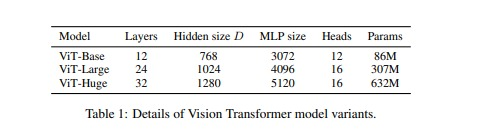

## 4. Eqaution 1: spliting data into patches and creating the class, position and patch embedding

layers = input -> function -> output

whats the input shape?

whats the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channels)
* output shape: ** Equation 1 **
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathrm{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.
**Equation 1**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* input shape : H * W * C (height x width x color channels)
* Output shape = N * (P^2 . C)
* H =  height
* W = width
* C =  color channels
* P = patch size
* N = number of patches = (height * width)/p^2
* D =  constant latent vector size = embedding dimension

In [14]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [15]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


## 4.2 Turning a single image into patches

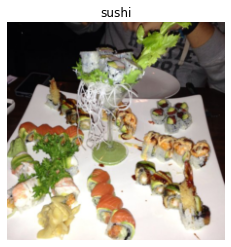

In [16]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

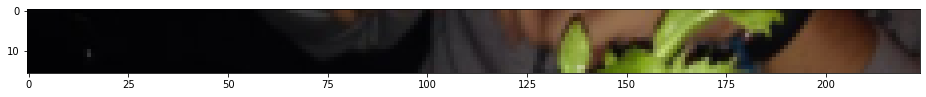

In [17]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels) 
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]); # heigth width color

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


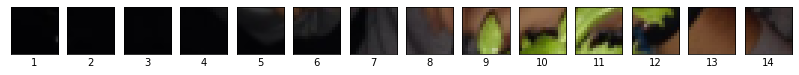

In [18]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


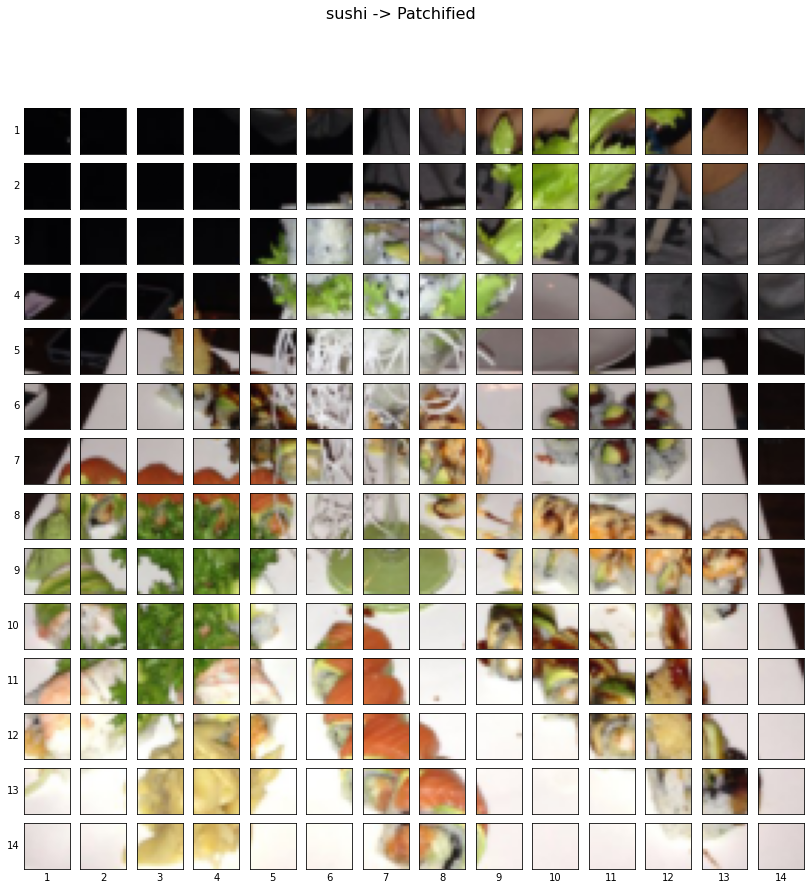

In [19]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

## 4.3 Create image patches with torch.nn.Conv2d()

In [20]:
# craete conv2d layer to turn images into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

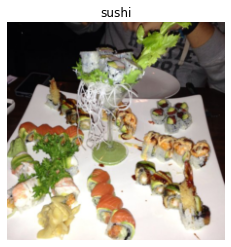

In [21]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [22]:
# Pass the image through the convolutional layer 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we have passed a single image to our conv2d layer its shape

```torch.Size([1, 768, 14, 14]) # batch_size, embedding_dim, feature_map_height, feature_map_width]```

In [23]:
image_out_of_conv.requires_grad

True

Showing random convolutional feature maps from indexes: [608, 617, 407, 579, 616]


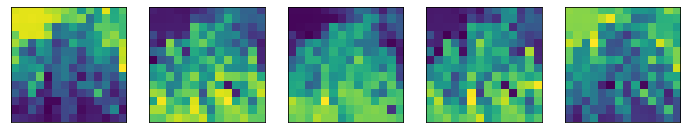

In [24]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [25]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0104, -0.0032, -0.0019,  0.0112,  0.0626,  0.0386,  0.1616,
            0.2739,  0.3798,  0.3800,  0.2939,  0.1703,  0.2556,  0.2315],
          [-0.0049, -0.0033, -0.0021,  0.0017,  0.0165,  0.2378,  0.3447,
            0.2052,  0.2694,  0.4479,  0.2012,  0.3106,  0.3175,  0.3476],
          [-0.0029,  0.0088,  0.0087,  0.0111,  0.4215,  0.8259,  0.6452,
            0.5529,  0.5186,  0.3506,  0.2295,  0.2396,  0.3110,  0.3503],
          [ 0.0400,  0.0141,  0.0862,  0.0484,  0.2866,  0.5223,  0.7298,
            0.7554,  0.4838,  0.5665,  0.5040,  0.2445,  0.1580,  0.2576],
          [ 0.0811,  0.4469,  0.6739,  0.1672,  0.6374,  1.0038,  0.9680,
            0.7042,  0.6175,  0.5585,  0.4174,  0.2961,  0.1208,  0.1109],
          [ 0.0794,  0.7869,  0.8201,  0.4038,  0.3884,  0.8000,  0.7378,
            0.5994,  0.9409,  0.4549,  0.4303,  0.5505,  0.5117,  0.0376],
          [ 0.3105,  0.6315,  0.5351,  0.5687,  0.5192,  0.7949,  0.7004,
            0.6742,  0.8198,  0.

## 4.4 Flattening the patch embedding with ```torch.nn.flatten()```

In [26]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [27]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


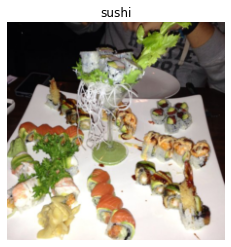

In [28]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [29]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


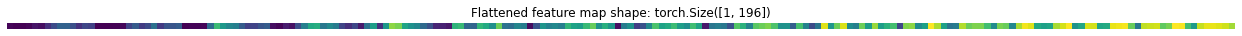

In [30]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [31]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[ 0.0104, -0.0032, -0.0019,  0.0112,  0.0626,  0.0386,  0.1616,  0.2739,
           0.3798,  0.3800,  0.2939,  0.1703,  0.2556,  0.2315, -0.0049, -0.0033,
          -0.0021,  0.0017,  0.0165,  0.2378,  0.3447,  0.2052,  0.2694,  0.4479,
           0.2012,  0.3106,  0.3175,  0.3476, -0.0029,  0.0088,  0.0087,  0.0111,
           0.4215,  0.8259,  0.6452,  0.5529,  0.5186,  0.3506,  0.2295,  0.2396,
           0.3110,  0.3503,  0.0400,  0.0141,  0.0862,  0.0484,  0.2866,  0.5223,
           0.7298,  0.7554,  0.4838,  0.5665,  0.5040,  0.2445,  0.1580,  0.2576,
           0.0811,  0.4469,  0.6739,  0.1672,  0.6374,  1.0038,  0.9680,  0.7042,
           0.6175,  0.5585,  0.4174,  0.2961,  0.1208,  0.1109,  0.0794,  0.7869,
           0.8201,  0.4038,  0.3884,  0.8000,  0.7378,  0.5994,  0.9409,  0.4549,
           0.4303,  0.5505,  0.5117,  0.0376,  0.3105,  0.6315,  0.5351,  0.5687,
           0.5192,  0.7949,  0.7004,  0.6742,  0.8198,  0.9285,  0.6203,  0.7607,
           0.639

## 4.5 Turning the VIT patch embedding layer into a pytorch modlue

we want this module to do a few things:
1. Create a class called `PatchEmbedding`
2. Initialize with appropriate hyperparambeters, such as channels, embedding dimension, patch size.
3. Create layer to turn an image into embedding patches with `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding

In [32]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [33]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")


Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [34]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# create class token embeding as a learnable parameter that shared the same size as the embeding
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [35]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [36]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0401, -0.0039, -0.0312,  ...,  0.0205, -0.0061,  0.0200],
         [-0.0341, -0.0086, -0.0352,  ...,  0.0210, -0.0081,  0.0093],
         ...,
         [-1.0197,  0.1970, -0.2850,  ...,  0.7419, -0.4471,  0.3496],
         [-0.9907,  0.2716, -0.2059,  ...,  0.6858, -0.4283,  0.3093],
         [-0.8795,  0.2194, -0.2424,  ...,  0.6616, -0.4148,  0.3272]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


# 4.7 Creating the position embedding
want to create a series of 1D learnable position embedding and to add them to sequence of patch embeddings

In [37]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0401, -0.0039, -0.0312,  ...,  0.0205, -0.0061,  0.0200],
          [-0.0341, -0.0086, -0.0352,  ...,  0.0210, -0.0081,  0.0093],
          ...,
          [-1.0197,  0.1970, -0.2850,  ...,  0.7419, -0.4471,  0.3496],
          [-0.9907,  0.2716, -0.2059,  ...,  0.6858, -0.4283,  0.3093],
          [-0.8795,  0.2194, -0.2424,  ...,  0.6616, -0.4148,  0.3272]]],
        grad_fn=<CatBackward0>), torch.Size([1, 197, 768]))

In [38]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1, 
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [39]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [ 0.9599,  0.9961,  0.9688,  ...,  1.0205,  0.9939,  1.0200],
         [ 0.9659,  0.9914,  0.9648,  ...,  1.0210,  0.9919,  1.0093],
         ...,
         [-0.0197,  1.1970,  0.7150,  ...,  1.7419,  0.5529,  1.3496],
         [ 0.0093,  1.2716,  0.7941,  ...,  1.6858,  0.5717,  1.3093],
         [ 0.1205,  1.2194,  0.7576,  ...,  1.6616,  0.5852,  1.3272]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


# 4.8 Putting it all together: from mage to embedding

lets see all in one cell

In [40]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


# 5. Equation 2: Multi-Head attention(MSA) MULTI HEAD SELF ATTENTION

In [41]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first? ( batch, seq, feature) -> (batch, number of patches, embedding dimension)
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [42]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1 
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])
